<a href="https://colab.research.google.com/github/BenJMaurel/Wine_project/blob/main/wine_project_13_12_Julien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partie 0 : Quelques imports de bon fonctionnement

The general idea of this project is to design a way for a casual wine enthusiast to know if a wine is good or not just thanks to a critic of someone commonly known as a "good wine taster".

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random as rd

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [5]:
import csv
#Permet de lire facilement le fichier GloVe (vectorisation des mots dans un evn de dim 50)
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [6]:
def convert_to_one_hot(vecteur):
    n_values = int(np.max(vecteur) + 1)
    oh = np.eye(n_values)[vecteur]
    return oh

In [10]:
data = pd.read_csv("/content/drive/My Drive/Wine_project/winemag-data-130k-v2.csv")
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [11]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/My Drive/Wine_project/glove.6B.50d.txt')

# Partie 1: Statistiques descriptives

In [35]:
data_stat = data.copy()
data_stat = data_stat.drop('Unnamed: 0', axis = 1)
data_stat.columns


Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [36]:
data_stat['country'].nunique()
data_stat['region_2'].nunique()
data_stat['province'].count()

129908

In [37]:
data_stat.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


On remarque ici que les notes, même si elles sont données sur 100, ne varient que entre 80 et 100.

In [38]:
data_stat.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## A. Etude de la variable 'points'
Dans un premier temps, nous allons étudier la variable 'points' qui est une variable chiffrée entre 80 et 100 et qui détermine la qualité du vin.

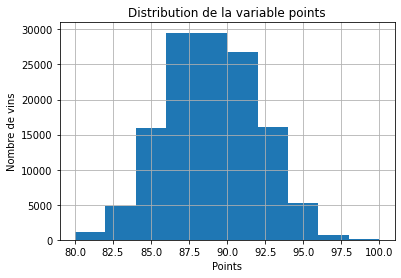

In [39]:
fig = data_stat['points'].hist()
plt.xlabel('Points')
plt.ylabel('Nombre de vins')
plt.title('Distribution de la variable points')
plt.show()

Comme on peut s'y attendre, la distribution des notes n'est pas équitable. Il y a beaucoup de vins notés entre 85 et 95, et très peu pour des notes très faibles ou très fortes. Cette distribution pourra poser problème par la suite pour réussir à déterminer 

Par la suite, on regroupera les points dans 5 groupes différents. On créé alors une nouvelle variable 'note' :
- note = 0 ssi 80 < points < 84
- note = 1 ssi 84 < points < 88
- note = 2 ssi 88 < points < 92
- note = 3 ssi 92 < points < 96
- note = 4 ssi 96 < points < 100

On étudie ça distribution :

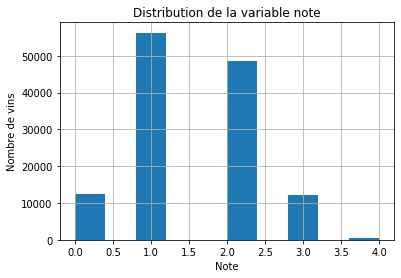

In [63]:
data_stat['note'] = (data_stat['points']-data_stat['points'].min())//4.001
fig = data_stat['note'].hist()
plt.xlabel('Note')
plt.ylabel('Nombre de vins')
plt.title('Distribution de la variable note')
plt.show()

On retrouve ici une distribution non égalitaire, les notes 0 et surtout 4 sont très peu représentées. Dans la suite, cela pourra poser problème pour évaluer des très mauvais ou des très bon vins.

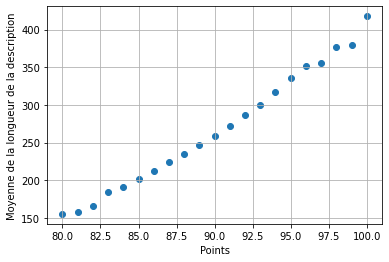

In [91]:
data_stat['round_points'] = data_stat['points'].round()
liste_desc = np.array(data['description'])
liste_longueur_com = [len(com) for com in liste_desc]
data_stat['longueur_com'] = pd.Series(liste_longueur_com)
meanByPoint = data_stat.groupby(by='round_points').mean()
meanByNote = data_stat.groupby(by='note').mean()
## meanByPoint est une dataframe des moyennes des variables quantitatives après un regroupement par point##
## meanByNote est une dataframe des moyennes des variables quantitatives après un regroupement par note##
plt.scatter(meanByPoint.index,meanByPoint['longueur_com'])
plt.grid()
plt.xlabel('Points')
plt.ylabel('Moyenne de la longueur de la description')
plt.show()

Il est amusant de voir une certaine relation affine entre la longueur de la description et les points d'un vin.

##B. Etude de la variable 'price'
La variable 'price' représente le prix de chaque vin. Etudions sa distribution :

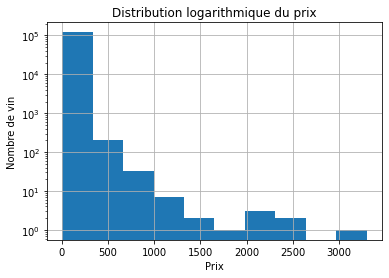

In [73]:
fig = data_stat['price'].plot(kind='hist',logy=True)
plt.grid()
plt.xlabel('Prix')
plt.ylabel('Nombre de vins')
plt.title('Distribution logarithmique du prix')
plt.show()

On remarque imédiatement que la majorité des vins de notre base de donnée est comprise entre en dessous de 250€. Néanmoins, certaines valeurs peuvent attendre les 3000€. Certaines valeurs extrêmes pourraient être à enlever de notre modèle.

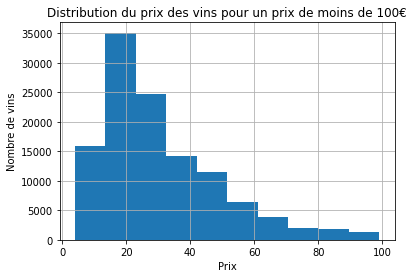

In [82]:
fig = data_stat[data_stat['price']<100]['price'].hist()
plt.xlabel('Prix')
plt.ylabel('Nombre de vins')
plt.title('Distribution du prix des vins pour un prix de moins de 100€')
plt.show()

En détaillant la distribution pour des prix en dessous de 100€, on remarque que beaucoup des vins référencés dans notre base de données ont des prix compris entre 10 et 40€, ce qui correspond bien aux prix des vins que l'on peut trouver le plus.

##C. Etude croisée des variables
Nous allons dans cette partie nous intéresser à l'étude des variables 'points' et 'price' lorsque l'on s'intéresse aux deux en même temps.

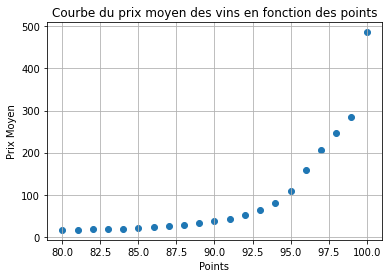

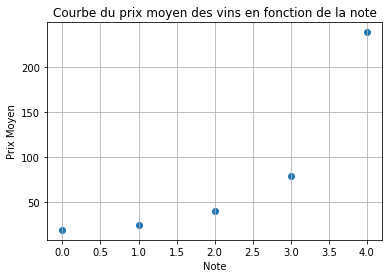

In [94]:
plt.scatter(meanByPoint['points'],meanByPoint['price'])
plt.grid()
plt.xlabel('Points')
plt.ylabel('Prix Moyen')
plt.title('Courbe du prix moyen des vins en fonction des points')
plt.show()

plt.scatter(meanByNote.index,meanByNote['price'])
plt.grid()
plt.xlabel('Note')
plt.ylabel('Prix Moyen')
plt.title('Courbe du prix moyen des vins en fonction de la note')
plt.show()

In [98]:
print('la corrélation entre le prix moyen et les points est de : '+str(meanByPoint['points'].corr(meanByPoint['price'])))

la corrélation entre le prix moyen et les points est de : 0.7965406000826235


On remarque, comme on peut s'y attendre, qu'il y a une corrélation forte entre le prix moyen par points et le nombre de points : plus le prix est élevé, plus les points sont proches de 100.

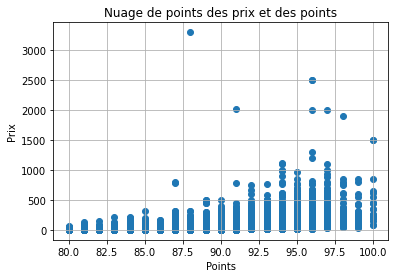

La corrélation entre le prix et les points est de : 0.4161667418606222


In [102]:
plt.scatter(data_stat['points'],data_stat['price'])
plt.grid()
plt.xlabel('Points')
plt.ylabel('Prix')
plt.title('Nuage de points des prix et des points')
plt.show()
print('La corrélation entre le prix et les points est de : '+str(data_stat['points'].corr(data_stat['price'])))

Néanmoins, cette relation est à relativiser lorsque l'on s'intéresse à l'ensemble des prix de notre base de données. La corrélation entre les deux chute énormément. On peut d'ailleurs remarquer que le vin ayant le prix le plus élevé de notre base de données n'a que 88 points sur 100 !

##D. Etude des vins Français
Nous allons dans cette partie nous pencher un petit peu plus sur les vins français et les comparer avec les vins des autres pays. Voyons voir si la France mérite sa réputation concernant la qualité de son vin...

In [147]:
data_stat[data_stat['country']=='France']['country'].count()

22093

Il y a donc 22093 vins français sur les 129908 qui composent notre base de données. Ce qui représente 17% de la base de données ! Elle même composée de 63 pays différents. La France est donc largement bien représentée dans cette base de données

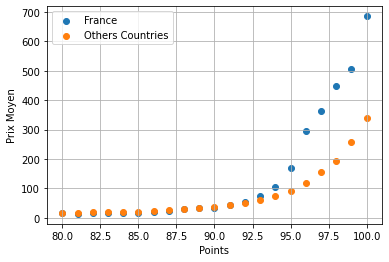

In [110]:
data_stat_FR = data_stat[data_stat['country']=='France']
meanByPoint_FR = data_stat_FR.groupby(by='round_points').mean()
data_stat_others = data_stat[data_stat['country']!='France']
meanByPoint_others = data_stat_others.groupby(by='round_points').mean()

plt.scatter(meanByPoint.index,meanByPoint_FR['price'],label='France')
plt.scatter(meanByPoint.index,meanByPoint_others['price'],label='Others Countries')
plt.grid()
plt.legend()
plt.xlabel('Points')
plt.ylabel('Prix Moyen')
plt.show()

In [ ]:
En comparaison aux autres pays, pour des vins de bonne qualité, il faudra dépenser davantage en France. Alors que pour un vin de moins bonne qualité, le prix reste assez similaire.

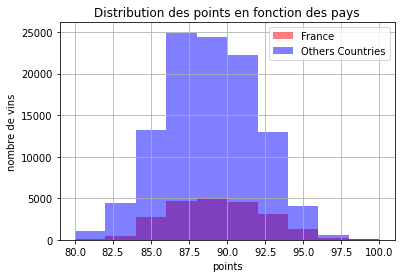

In [142]:
fig1 = data_stat_FR['points'].hist(alpha=0.5,color='r',label='France')
fig2 = data_stat_others['points'].hist(alpha=0.5,color='b',label='Others Countries')
plt.legend()
plt.xlabel('points')
plt.ylabel('nombre de vins')
plt.title('Distribution des points en fonction des pays')
plt.show()

              France  Others   Pourcent
round_points                           
80                15     382   3.778338
81                36     656   5.202312
82               107    1728   5.831063
83               301    2723   9.953704
84              1088    5390  16.795307
85              1709    7820  17.934726
86              2024   10571  16.069869
87              2594   14333  15.324629
88              2898   14300  16.850797
89              2129   10079  17.439384
90              2538   12865  16.477310
91              2030    9323  17.880736
92              1710    7896  17.801374
93              1393    5096  21.467098
94               856    2902  22.778073
95               413    1122  26.905537
96               145     378  27.724665
97                70     159  30.567686
98                21      56  27.272727
99                 8      25  24.242424
100                8      11  42.105263


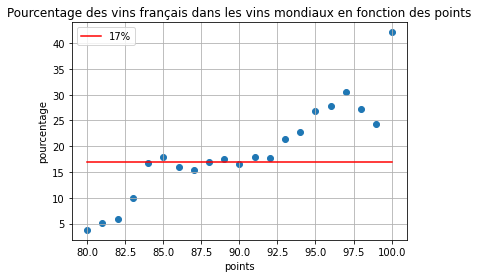

In [150]:
data_compare = pd.DataFrame()
data_compare['France'] = data_stat_FR.groupby(by='round_points').count()['country']
data_compare['Others'] = data_stat_others.groupby(by='round_points').count()['country']
data_compare['Pourcent'] = data_compare['France']/(data_compare['France']+data_compare['Others'])*100
##Pourcent représente le pourcentage des vins français dans l'ensemble des vins de notre base de données à chaque point##
print(data_compare)

plt.scatter(data_compare.index,data_compare['Pourcent'])
plt.plot(list(data_compare.index),[17 for i in range(len(list(data_compare.index)))],color='r',label='17%')
plt.grid()
plt.legend()
plt.title('Pourcentage des vins français dans les vins mondiaux en fonction des points')
plt.xlabel('points')
plt.ylabel('pourcentage')
plt.show()

On a donc vu que les vins français représentes 17% de notre base de données. D'après l'étude précédente, on remarque que les vins français sont davantage compris dans les vins de bonne qualité que dans les vins ayant les moins bonnes notes.

# Partie 2 : Premier Modèle

## Modèle 1.1

In [ ]:
data_1 = data.sample(frac = 1, random_state = 1)
X = data_1['description']
Y = data_1['points']

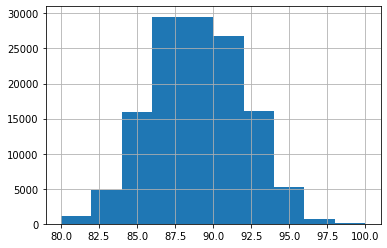

In [ ]:
fig = Y.hist()
plt.show()

On va essayer de prédire, en fonction de la description, un score en séparant en 5 parties égales l'ensemble des scores possibles

In [ ]:
groupe = (max(Y)-min(Y))/5
print("on va faire 5 catégories de taille", groupe+0.001)

on va faire 5 catégories de taille 4.001


In [ ]:
# Creating the 5 classes, transform X, Y into array

Y = np.array(Y)
X = np.array(X)
mini = min(Y)
for idx in range(len(Y)):
    Y[idx] = abs(Y[idx] - mini)//4.001   

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)
Y_train = np.array(Y_train, dtype = int)

The model is simple: thanks to the glove document, we will be able to transform a word into a vector.

1.   We do that for every word in the descrption
2.   sum up the vectors and take the average


This give us "an idea" of the sentence (if the sentence is positive or negative)

It will be our new X in the regression

In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    ''' 
    
    This function transform a sentence into a representative vector
    Arguments :
    sentence        -- str correspond to the critics of the wine
    word_to_vec_map --  give the vector associated to the word in GloVe doc
    Returns :
    avg -- vector of dim 50
    
     '''
    #Step 1: transform the str sentence into a list of words
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(50)
    
    # Step 2: average the word vectors.
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 800):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations): 
        for i in range(m):          
            
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W,avg) + b
            a = softmax(z)

            cost = - np.dot(Y_oh[i],np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Arguments :
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                      
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # initialising avg
        avg = np.zeros((50,))
        for w in words:
          #Some problems occur with ".split()", sometimes we don't want the first or the last character.
          #Kind of the hard way to do it, but it works...
            while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [ ]:
#Training the model
pred, W, b = model(X_train, Y_train, word_to_vec_map)

KeyboardInterrupt: ignored

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5316918341829374
Test set:
Accuracy: 0.5257692307692308


On se retrouve avec une accuracy de 50%. Ce qui est déjà bien mieux que le hasard (5 catégories) mais à nuancer par le choix de nos catégories... (cf modèle 1.2)

In [ ]:
#A little test to see if it works...
X_my_sentences = np.array(["I love that wine, it is so tasteful. A great success to see in the future"])
Y_my_labels = np.array([[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 1.0


array([[3.]])

Vérifions à partir d'une matrice de confusion si les résultats sont pertinents

In [ ]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap)

    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Predicted  0.0  1.0   2.0  3.0   All
Actual                              
0           42  144    69    0   255
1           30  555   537    1  1123
2            5  192   765    6   968
3            0    9   235    5   249
4            0    0     5    0     5
All         77  900  1611   12  2600


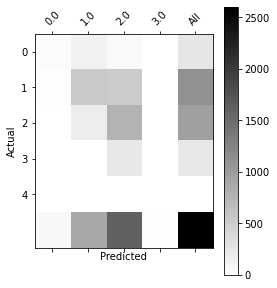

In [ ]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

La taille des catégories a été mal évaluée. Essayons de remedier à ça dans la partie 2:

## Modèle 1.2

Puisqu'on a une distribution pour Y qui ressemble à une loi normale et non une loi uniforme, on essai cette fois de séparer les classes en fonction des quantiles (20% pour chaque classe) et on reteste le modèle à partir de ça

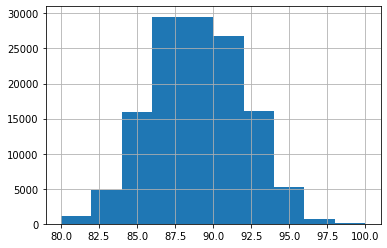

In [ ]:
data_12 = data.sample(frac = 1, random_state = 1)
X = data_12['description']
Y = data_12['points']
quant = Y.quantile([0.2,0.4,0.6,0.8,1])
fig = Y.hist()
plt.show()

In [ ]:
#This is the only difference with model 1.1: approximatively 20% of the values are in each classes
#Note that it is possible to optimize the running time by using vectorial calcul and mask 
Y = np.array(Y)
for idx in range(len(Y)):
    if Y[idx] <= quant[0.2] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 0
    elif Y[idx] <= quant[0.4] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 1
    elif Y[idx] <= quant[0.6] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 2
    elif Y[idx] <= quant[0.8] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 3
    else:
        Y[idx] = 4

In [ ]:
#Split the set in train/test
X = np.array(X)
Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)


In [ ]:
#train the model
pred, W_1, b_1 = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 --- cost = 1.251617408204892
Accuracy: 0.4122874509502193
Epoch: 100 --- cost = 1.0574265848015216
Accuracy: 0.4160383165345849
Epoch: 200 --- cost = 1.0652126020780248
Accuracy: 0.4159325228898977
Epoch: 300 --- cost = 1.0695619001746706
Accuracy: 0.41574978841271065
Epoch: 400 --- cost = 1.0720231460451917
Accuracy: 0.41589405247364775
Epoch: 500 --- cost = 1.0734271980088497
Accuracy: 0.41588443486958526
Epoch: 600 --- cost = 1.0742362594881796
Accuracy: 0.41587481726552283
Epoch: 700 --- cost = 1.0747077164655379
Accuracy: 0.41585558205739787


In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W_1, b_1, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W_1, b_1, word_to_vec_map)


In [ ]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

We could expect it, the accuracy value decreases.
To try to have better accuracy we'll use a LSTM model which interpret the whole sentence.

# Partie 3 : Modèle LSTM

Using tensorflow and keras for that model

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

The hudge difference here with Model 1 is that we care about the lenght of the description.
So we just put aside any descrption which is "too" long.

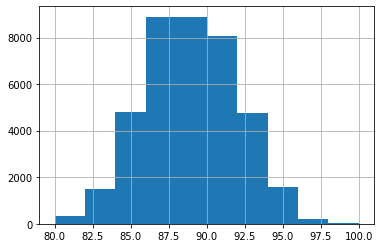

In [ ]:
data_3 = data.sample(frac = 0.3, random_state = 1)
data_3= data_3.sort_values(by=['points'])
X_LTSM = data_3['description']
Y = data_3['points']

quant = Y.quantile([0.2,0.4,0.6,0.8,1])
fig = Y.hist()
plt.show()

X_LTSM = np.array(X_LTSM)
Y = np.array(Y)

#Here we check the size of each X
size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

#In order to mask the ones that are too long (here the 1% the longest)
mask = pd.Series(size)< np.quantile(size,0.99)

X_LTSM = X_LTSM[mask]
Y = Y[mask] 


for idx in range(len(Y)):
    if Y[idx] <= quant[0.2] and np.sum(Y ==0) < len(Y)/5:
        Y[idx] = 0
    elif Y[idx] <= quant[0.4] and np.sum(Y == 1) < len(Y)/5:
        Y[idx] = 1
    elif Y[idx] <= quant[0.6] and np.sum(Y == 2) < len(Y)/5:
        Y[idx] = 2
    elif Y[idx] <= quant[0.8] and np.sum(Y == 3) < len(Y)/5:
        Y[idx] = 3
    else:
        Y[idx] = 4


In [ ]:
size = size[mask]
size.max()
#This will be the size of each sentence. The sentence that are shorter will be
#completed with blank.

70

In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (str) into an array of indices corresponding to words in the sentences.
    
    Arguments:
    X -- array of sentences of shape (m, 1)
    word_to_index -- a dictionary containing each word mapped to its index
    max_len -- maximum number of words in a sentence. Here worth size.max() 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        sentence_words = X[i].lower().split()
        
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          #Same thing than in Modèle 1.1
          while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
          X_indices[i, j] = word_to_index[w]
          j += 1
            
    
    return X_indices

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """

    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                 
    
    emb_dim = word_to_vec_map["cucumber"].shape[0] 
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = True)

    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
def Wine_model(input_shape, word_to_vec_map, word_to_index):
    """
    LSTM Model and its differents layers
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map
    word_to_index 

    Returns:
    model -- a model instance in Keras
    """
    
    # Define Input layer
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)

    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)

    X = Dense( units = 5)(X)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [ ]:
model = Wine_model((size.max(),), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 50)            20000000  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 70, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Split into train/test sets
Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test = train_test_split(X_LTSM,Y,test_size=0.2)

In [ ]:
#Convert X and Y to fit the model size:
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())
Y_train_oh = convert_to_one_hot(Y_train)

In [ ]:
model.fit(X_train_indices, Y_train_oh, epochs = 10, batch_size = 1500, shuffle=True)

Epoch 1/10
21/21 [==============================] - 5s 248ms/step - loss: 1.0557 - accuracy: 0.5338
Epoch 2/10
21/21 [==============================] - 5s 249ms/step - loss: 1.0231 - accuracy: 0.5492
Epoch 3/10
21/21 [==============================] - 5s 250ms/step - loss: 1.0008 - accuracy: 0.5577
Epoch 4/10
21/21 [==============================] - 5s 250ms/step - loss: 0.9775 - accuracy: 0.5746
Epoch 5/10
21/21 [==============================] - 5s 241ms/step - loss: 0.9564 - accuracy: 0.5875
Epoch 6/10
21/21 [==============================] - 5s 247ms/step - loss: 0.9381 - accuracy: 0.5977
Epoch 7/10
21/21 [==============================] - 5s 249ms/step - loss: 0.9489 - accuracy: 0.5909
Epoch 8/10
21/21 [==============================] - 5s 243ms/step - loss: 0.9246 - accuracy: 0.6055
Epoch 9/10
21/21 [==============================] - 5s 241ms/step - loss: 0.9007 - accuracy: 0.6195
Epoch 10/10
21/21 [==============================] - 5s 244ms/step - loss: 0.8616 - accuracy: 0.6446

In [ ]:
#Test:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = size.max())
Y_test_oh = convert_to_one_hot(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
pred = model.predict(X_test_indices)
pred = np.argmax(pred, axis = 1) 
print()
print("Test accuracy = ", acc)

242/242 [==============================] - 1s 6ms/step - loss: 1.3070 - accuracy: 0.4775

Test accuracy =  0.47749030590057373


Predicted     0     1     2     3     4   All
Actual                                       
0          1120   339    89     8     2  1558
1           544   659   251    79     8  1541
2           171   524   532   252    60  1539
3            32   220   495   538   313  1598
4             4    67   183   398   842  1494
All        1871  1809  1550  1275  1225  7730


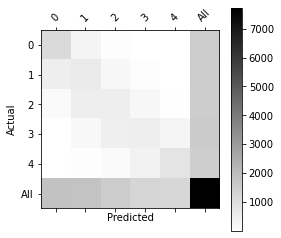

In [ ]:
print(pd.crosstab(Y_test, pred.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred)

That kind of confusion matrix is far better! 
We have now something which seems pretty decent.

But can we go further? Is it possible to evaluate directly the value of the score?

 # Partie 4: Le retour du modèle 1

Let's try it.

In that part we will try to evaluate the value of the score directly and try to put the price in the X to gain more precision.

In [ ]:
#A new sentence_to_avg must be defined because we have to had prices in the X values.

def sentence_to_avg(sentence, word_to_vec_map):
 
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. 
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

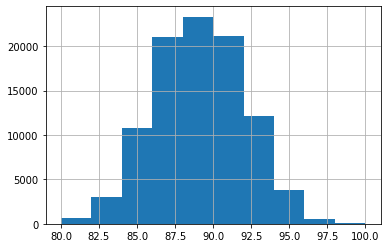

In [ ]:
data_4 = data[['description', 'points', 'price', 'taster_name']].sample(frac = 1, random_state = 1)
data_4 = data_4.dropna()
X = data_4['description']
Y = data_4['points']
prices = data_4['price']

fig = Y.hist()
plt.show()

Y = np.array(Y)
m=len(X)

#Some preprocessing on X...

X = np.array(X)
X_emb = np.zeros((m,50)) 
prices = np.array(prices)
prices = np.log(prices)
prices = prices - prices.mean()
for i in range(m): 
  X_emb[i] = sentence_to_avg(X[i], word_to_vec_map)
X_emb = np.column_stack((X_emb,prices))

Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_emb,Y,test_size=0.2)

In [ ]:
def relu(x):
    if x <0:
        x = 0
    return x

In [ ]:
def model_4(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 1                                 # number of classes  
    n_h = 51                               # dimensions of the GloVe vectors + 1 (for price)
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
          
            # Forward propagate the avg through the softmax layer
            z = np.dot(W,X[i]) + b
            a = relu(z)
            
            # Compute gradients 
            dz = a - Y[i]
            dW = np.dot(dz.reshape(n_y,1), X[i].reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t))
            pred = predict_4(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
def predict_4(X, Y, W, b, word_to_vec_map):
    """
    Arguments:
    X -- input data containing avg and prices, numpy array of shape (m, 51)
    Y -- labels, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros(m)
    
    for j in range(m):                       # Loop over training examples
        
        # Forward propagation
        Z = np.dot(W, X[j]) + b
        A = relu(Z)
        pred[j] = A[0]
        
    print("Loss (=mse): "  + str(np.square(np.subtract(Y,pred)).mean() ))
    
    return pred

In [ ]:
pred, W_4, b_4 = model_4(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0
Loss: 5.503880041470268
Epoch: 100
Loss: 4.613893564036255
Epoch: 200
Loss: 4.612016620854619
Epoch: 300
Loss: 4.611877771992524
[85.84995618 89.08292203 89.55358897 ... 87.12488958 89.42881855
 88.38939434]


In [ ]:
print("Training set:")
pred_train = predict_4(X_train, Y_train, W_4, b_4, word_to_vec_map)
print('Test set:')
pred_test = predict_4(X_test, Y_test, W_4, b_4, word_to_vec_map)

Training set:
Loss: 4.611867435419702
Test set:
Loss: 4.6284941374251565


In [ ]:
#Let's try to analyse our prediction:
ecart = []
for i in range(0,len(Y_test)):
 ecart.append(abs(pred_test[i] - Y_test[i]))
ecart = np.array(ecart)
print("ecart max:" +str(np.max(ecart)))
print("ecart moy:"+ str(ecart.mean()))
print("variance de l'écart:" + str(ecart.var()))
print(np.quantile(ecart, 0.9))

ecart max:10.510670238903003
ecart moy:1.6969327532760465
variance de l'écart:1.7489133682841334
3.500728268783739


In [ ]:
#Si on veut comparer aux modèles précédents:

Y_test = pd.Series(Y_test)
quant = Y_test.quantile([0.2,0.4,0.6,0.8,1])
Y_res = np.array(Y_test)

for idx in range(len(Y_test)):
    if Y_res[idx] <= quant[0.2]:
        Y_res[idx] = 0
    elif Y_res[idx] <= quant[0.4]:
        Y_res[idx] = 1
    elif Y_res[idx] <= quant[0.6]:
        Y_res[idx] = 2
    elif Y_res[idx] <= quant[0.8]:
        Y_res[idx] = 3
    else:
        Y_res[idx] = 4

pred_test= pd.Series(pred_test)
quant_pred = pred_test.quantile([0.2,0.4,0.6,0.8,1])
pred_res = np.array(pred_test)

for idx in range(len(Y_test)):
    if pred_res[idx] <= quant_pred[0.2]:
        pred_res[idx] = 0
    elif pred_res[idx] <= quant_pred[0.4]:
        pred_res[idx] = 1
    elif pred_res[idx] <= quant_pred[0.6]:
        pred_res[idx] = 2
    elif pred_res[idx] <= quant_pred[0.8]:
        pred_res[idx] = 3
    else:
        pred_res[idx] = 4

print(pd.crosstab(Y_res, pred_res.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_res, pred_res)


Predicted   0.0   1.0   2.0   3.0   4.0    All
Actual                                        
0          2479  1269   591   246    82   4667
1          1047  1511  1385   840   341   5124
2           194   455   559   513   250   1971
3           126   553  1004  1393  1163   4239
4            14    71   320   867  2023   3295
All        3860  3859  3859  3859  3859  19296


NameError: ignored

In [ ]:
str('Accuracy: ' + str(np.mean(pred_res[:] == Y_res[:]) ) )

'Accuracy: 0.41277985074626866'

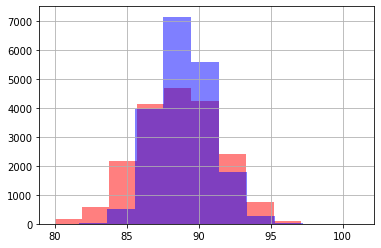

In [ ]:
#Here the distribution can also give us some hints of the quality of the prediction
fig1 = Y_test.hist(alpha = 0.5, color = 'r')
fig2 = pred_test.hist(alpha = 0.5, color = 'b')

plt.show()

# Partie 5 : Retour sur LSTM

This time we will try to get the score directly in output using the LSTM model. The only thing that really changes from the previous LSTM model is the loss function...

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [ ]:
data_5 = data.sample(frac = 1, random_state = 1)
data_5= data_5.sort_values(by=['points'])
X_LTSM = data_5['description']
Y_LTSM = data_5['points']

print(len(X_LTSM))
X_LTSM = np.array(X_LTSM)

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask = pd.Series(size) <= np.quantile(size,0.99)
X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)

X_LTSM = X_LTSM[mask]
Y_LTSM = Y_LTSM[mask] 
size = size[mask] 

#Preprocessing of the Y values:
min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)

size.max()

129971


71

In [ ]:
#Split train/test

X_train,X_test,Y_train,Y_test = train_test_split(X_LTSM,Y_LTSM,test_size=0.2)
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())

In [ ]:
def Wine_model_2(input_shape, word_to_vec_map, word_to_index):
    """
    Arguments:
    input_shape -- shape of the input, here size.max()
    word_to_vec_map
    word_to_index 

    Returns:
    model -- model instance in Keras
    """
    
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(128, return_sequences= True)(embeddings)
    X = Dropout(0.5)(X)
    
    X = LSTM(128, return_sequences= False)(X)
    X = Dropout(0.5)(X)
    
    #We just had a new 128 Dense Layer (because it works better...)
    X = Dense ( units = 128 )(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    X = Dense( units = 1 )(X)
    X = Activation('linear')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [ ]:
model_2 = Wine_model_2((size.max(),), word_to_vec_map, word_to_index)
model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 71, 50)            20000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 71, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 71, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [ ]:
# Compute that to load a model : 

from keras.models import model_from_json
from keras.models import load_model


json_file = open('/content/drive/My Drive/Wine_project/final_p5.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model_2.load_weights("/content/drive/My Drive/Wine_project/final_p5.hdf5")
print("Loaded model from disk")
model_2.save('/content/drive/My Drive/Wine_project/final_p5.hdf5')
model_2=load_model('/content/drive/My Drive/Wine_project/final_p5.hdf5')
from keras import metrics
model_2.compile(optimizer = 'adam', loss= 'mean_squared_error', metrics= [metrics.mean_squared_error, metrics.mean_absolute_error]) 


Loaded model from disk


In [ ]:
from keras import metrics
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])

In [ ]:
model_2.fit(X_train_indices, Y_train, epochs = 3, batch_size = 1500, shuffle=True)

Epoch 1/3
69/69 [==============================] - 17s 251ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0653
Epoch 2/3
69/69 [==============================] - 17s 252ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0644
Epoch 3/3
69/69 [==============================] - 17s 249ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0636


In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss, mse, mae = model_2.evaluate(X_test_indices, Y_test)
pred = model_2.predict(X_test_indices)

805/805 [==============================] - 4s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0568


In [ ]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model_2.to_json()
with open("/content/drive/My Drive/Wine_project/final_p5.json", "w") as json_file:
  json_file.write(model_json)
model_2.save_weights("/content/drive/My Drive/Wine_project/final_p5.hdf5")

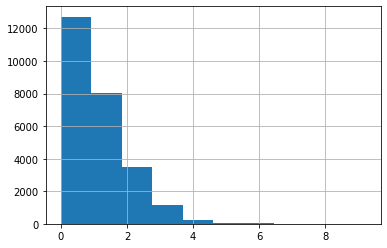

In [ ]:
pred_post,Y_test_post = pred*(max_Y - min_Y) + min_Y,Y_test*(max_Y - min_Y) + min_Y
pred_post = np.reshape(pred_post,(len(pred)))
ecart = abs(pred_post - Y_test_post)
pd.Series(ecart).hist()
plt.show()

In [ ]:
np.quantile(ecart, 0.90)

2.3747497558593755

In [ ]:
#petit test aléatoire:
i = rd.randint(0,len(pred_post))
print("Prédiction:" + str(pred_post[i]))
print("Réel :" +str(Y_test_post[i]))

Prédiction:87.7039
Réel :87.0


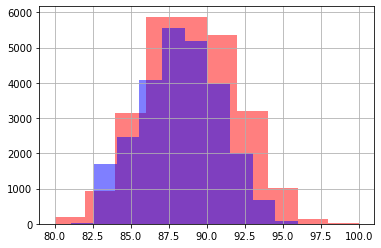

In [ ]:
fig1 = pd.Series(Y_test_post).hist(alpha = 0.5, color = 'r')
fig2 = pd.Series(pred_post).hist(alpha = 0.5, color = 'b')

plt.show()

We can see here thanks to the distribution that it looks like the LSTM model allow better range of values if we compare it to the Model_4.

In [ ]:
def predict_wine_score(sentence):
  #sentence MUST BE a string, it is the sentence describing the wine 
  #return the score (out of 100) predicted for the bottle described
  sentence = np.array([sentence])
  sentence = sentences_to_indices(sentence,word_to_index, size.max())
  return model_2.predict(sentence)[0][0]*(max_Y - min_Y) + min_Y

In [ ]:
#Petit exemple avec ce vin 
#https://www.vivino.com/FR/fr/sainte-marguerite-symphonie-cotes-de-provence-rouge/w/3496774?year=2018&price_id=22596529&cart_item_source=nav-explore
#noté 4.3/5 ce qui équivaut à 86/100

predict_wine_score("After the white, the red. Wine with a nice roundness, a nice spicy and fleshy side. It is powerful and subtle at the same time. It's organic and it's all good. One of my reference domains in Côtes de Provence.")

86.099613904953

## Prediction du prix

Puisque le modèle semble bien marcher, on tente notre chance en essayant de prédire le prix.

129970


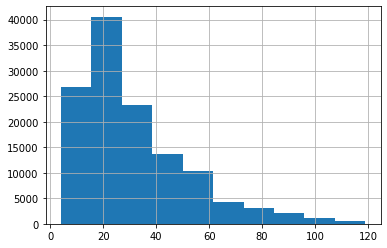

70

In [ ]:

data_51 = data.sample(frac = 1, random_state = 1)
X_LTSM = data_51['description']
Y_LTSM = data_51['price']
Y_LTSM = Y_LTSM.fillna(method='backfill')

mask = Y_LTSM.isnull() <1
Y_LTSM = Y_LTSM[mask]
X_LTSM = X_LTSM[mask]
print(len(X_LTSM))

mask1 = Y_LTSM < np.quantile(np.array(Y_LTSM),0.98)

X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)
X_LTSM = X_LTSM[mask1]
Y_LTSM = Y_LTSM[mask1]

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask2 = pd.Series(size) <= np.quantile(size,0.99)

X_LTSM = X_LTSM[mask2]
Y_LTSM = Y_LTSM[mask2] 

pd.Series(Y_LTSM).hist()
plt.show()

min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)
size = size[mask2]
size.max()


In [ ]:
#Split train/test

X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_LTSM,test_size=0.2)
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())

In [ ]:
# Compute that to load a model : 

from keras.models import model_from_json
from keras.models import load_model


json_file = open('/content/drive/My Drive/Wine_project/final_p5price.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model_2.load_weights("/content/drive/My Drive/Wine_project/final_p5price.h5")
print("Loaded model from disk")
model_2.save('/content/drive/My Drive/Wine_project/final_p5price.hdf5')
model_2=load_model('/content/drive/My Drive/Wine_project/final_p5price.hdf5')
model_2.compile(optimizer = 'adam', loss= 'mean_squared_error', metrics= [metrics.mean_squared_error, metrics.mean_absolute_error]) 

from keras import metrics
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])


OSError: ignored

In [ ]:
#Do not run it if you have already load a model
model_2 = Wine_model_2((size.max(),), word_to_vec_map, word_to_index)
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])
model_2.fit(X_train_indices, Y_train, epochs = 15, batch_size = 1500, shuffle=True)

Epoch 1/15
68/68 [==============================] - 18s 268ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1335
Epoch 2/15
68/68 [==============================] - 18s 266ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1164
Epoch 3/15
68/68 [==============================] - 18s 266ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1093
Epoch 4/15
68/68 [==============================] - 18s 266ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1044
Epoch 5/15
68/68 [==============================] - 18s 267ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1023
Epoch 6/15
68/68 [==============================] - 18s 265ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1002
Epoch 7/15
68/68 [==============================] - 18s 265ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.0972
Epoch 8/15
68

if an error pop up, make sure that you haave run all the required function to define model_2

In [ ]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model_2.to_json()
with open("/content/drive/My Drive/Wine_project/final_p5price.json", "w") as json_file:
  json_file.write(model_json)
model_2.save_weights("/content/drive/My Drive/Wine_project/final_p5price.hdf5")

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss, mse, mae = model_2.evaluate(X_test_indices, Y_test)
pred = model_2.predict(X_test_indices)

787/787 [==============================] - 4s 5ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1028


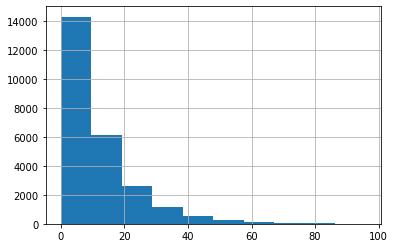

13.746586608886716

In [ ]:
pred_post,Y_test_post = pred*(max_Y - min_Y) + min_Y, Y_test*(max_Y - min_Y) + min_Y
pred_post = np.reshape(pred_post,(len(pred)))
ecart = abs(pred_post - Y_test_post)
pd.Series(ecart).hist()
plt.show()
np.quantile(ecart, 0.7)

In [ ]:
#petit test aléatoire:
i = rd.randint(0,len(pred_post))
print("Prédiction:" + str(pred_post[i]))
print("Réel :" +str(Y_test_post[i]))

Prédiction:17.050293
Réel :20.0


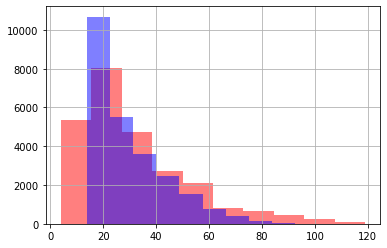

In [ ]:
fig1 = pd.Series(Y_test_post).hist(alpha = 0.5, color = 'r')
fig2 = pd.Series(pred_post).hist(alpha = 0.5, color = 'b')

plt.show()

# Conclusion


Le modèle donne déjà des résultats plutôt convaincants!
Cependant il existe encore de nombreuses pistes d'améliorations...
On pourrait se servir du prix pour mieux déterminer le score ou du score pour mieux déterminer le prix.
Il est également possible de prendre en compte l'auteur de la critique pour améliorer la prédiction.

Un autre problème du modèle et la difficulté qu'il a à prédire les prix extremes. Si nous nous intéressons à des bouteilles de très hautes qualité il devient rapidement inutile.

Globalement, ce modèle s'adresse à des acheteurs lambda qui doivent se forger rapidement une opinion d'une bouteille à partir d'une descrpition succinte.